In [9]:
# import os
# # Set working directory manually on Gadi to be able to load csv files
# user = os.getenv('USER')
# os.chdir('/scratch/cd82/'+user+'/notebooks/')

# XGBoost Classification with Heart Disease Dataset

**Gradient Boosting** is a powerful ensemble technique that builds models sequentially. Each new model is trained to correct the errors made by the previous models. The idea is to **minimize a loss function** (like log loss for classification or MSE for regression) by adding weak learners (usually shallow decision trees) in a stage-wise manner.

### 🔁 Core Idea of Gradient Boosting
At each step, a new model is trained to predict the **residuals (errors)** of the previous model:
$$
\text{Residual}_i = y_i - \hat{y}_i
$$
Then, this new model is added to the overall prediction:
$$
\hat{y}^{(t+1)} = \hat{y}^{(t)} + \eta \cdot h_t(x)
$$
Where:
- $ \hat{y}^{(t)} $: current prediction
- $ h_t(x) $: new weak learner (tree)
- $ \eta $: learning rate (controls the step size)

---

## 🚀 What is XGBoost?

**XGBoost (Extreme Gradient Boosting)** is an optimized version of gradient boosting that includes several improvements:
- **Regularization**: Prevents overfitting using $ L1 $ and $ L2 $ penalties.
- **Parallelization**: Faster training via parallel tree construction.
- **Handling of Missing Values**: Smart ways to deal with NaNs automatically.
- **Tree Pruning**: Uses a depth-first approach and pruning with a minimum loss reduction (`gamma`).
- **Column Subsampling**: Introduces randomness (like Random Forest) via `colsample_bytree`.

---

## 📉 Role of the Learning Rate ($ \eta $)

The **learning rate** determines how much each tree contributes to the final prediction. It's one of the most important hyperparameters in XGBoost:

| Learning Rate | Behavior                                                   |
|---------------|------------------------------------------------------------|
| High ($ \eta \approx 0.3 $)  | Faster learning but may overfit.                             |
| Low ($ \eta \approx 0.01 $) | Slower learning, but often better generalization. Needs more trees. |

A small learning rate with a high number of estimators is generally a safer and more robust approach.

---

📌 **Summary**:  
Gradient Boosting builds an ensemble of models to correct previous mistakes. XGBoost makes this process faster, more regularized, and scalable. The learning rate is a key tuning knob that balances speed and generalization.



We will focus on three key hyperparameters:
- `n_estimators`: Number of boosting rounds.
- `max_depth`: Maximum depth of a tree.
- `learning_rate`: Step size shrinkage used to prevent overfitting.

We’ll also evaluate model performance and interpret it using SHAP (SHapley Additive exPlanations).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import shap
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

df = pd.read_csv("heart.csv")
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 🔧 Hyperparameter Tuning: `n_estimators`

The `n_estimators` parameter defines the number of boosting rounds (trees). Increasing it can improve performance but might lead to overfitting.


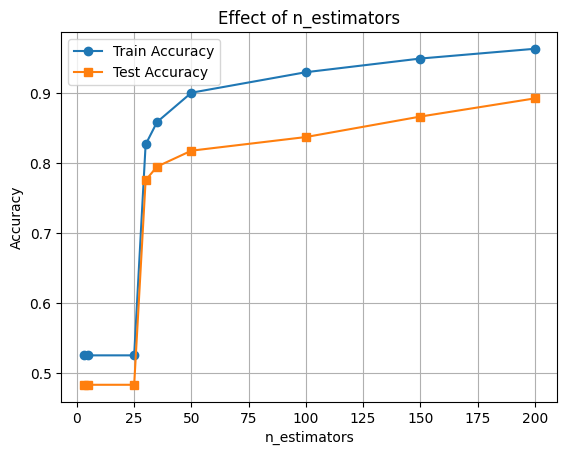

In [28]:
estimators = [3, 5, 25, 30, 35, 50, 100, 150, 200]
train_scores, test_scores = [], []

for n in estimators:
    clf = XGBClassifier(n_estimators=n, learning_rate=0.002,  eval_metric='logloss')
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(estimators, train_scores, marker='o', label='Train Accuracy')
plt.plot(estimators, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Effect of n_estimators')
plt.legend()
plt.grid(True)
plt.show()


## 🔧 Hyperparameter Tuning: `max_depth`

The `max_depth` parameter controls the complexity of each tree. Deeper trees can learn more complex patterns but may overfit.


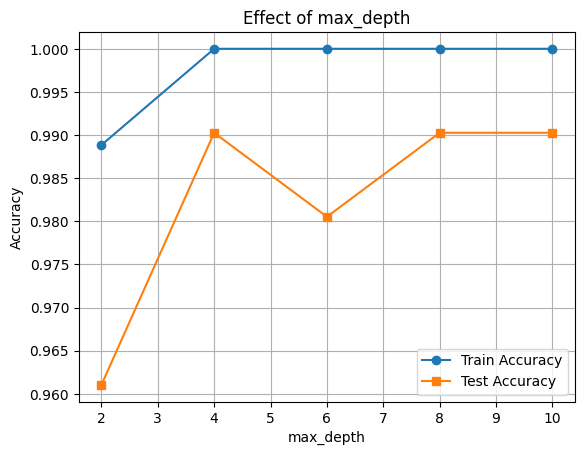

In [12]:
depths = [2, 4, 6, 8, 10]
train_scores, test_scores = [], []

for d in depths:
    clf = XGBClassifier(max_depth=d, eval_metric='logloss')
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(depths, train_scores, marker='o', label='Train Accuracy')
plt.plot(depths, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Effect of max_depth')
plt.legend()
plt.grid(True)
plt.show()


## 🔧 Hyperparameter Tuning: `learning_rate`

The `learning_rate` parameter shrinks the contribution of each tree. Lower values require more trees but improve generalization.


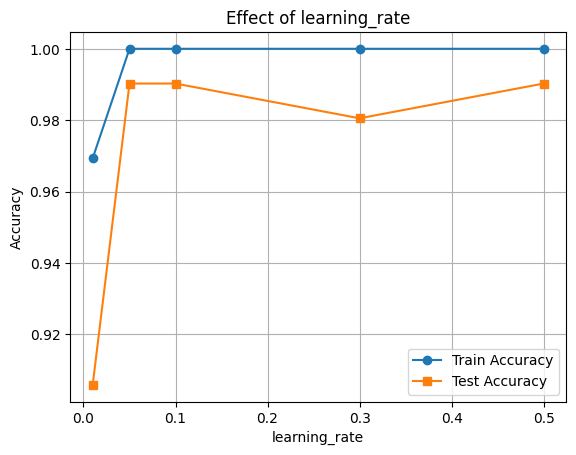

In [13]:
rates = [0.01, 0.05, 0.1, 0.3, 0.5]
train_scores, test_scores = [], []

for rate in rates:
    clf = XGBClassifier(learning_rate=rate, eval_metric='logloss')
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(rates, train_scores, marker='o', label='Train Accuracy')
plt.plot(rates, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')
plt.title('Effect of learning_rate')
plt.legend()
plt.grid(True)
plt.show()



## 🔍 Feature Importance with SHAP

Now let's interpret the model using **SHAP values** to see which features were most influential.


In [14]:
final_clf = XGBClassifier(learning_rate=0.1, max_depth=10,n_estimators=200, eval_metric='logloss')
final_clf.fit(X_train, y_train)

# Accuracy
train_acc = final_clf.score(X_train, y_train)
test_acc = final_clf.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Train Accuracy: 1.000
Test Accuracy: 0.990


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       159
           1       1.00      0.98      0.99       149

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



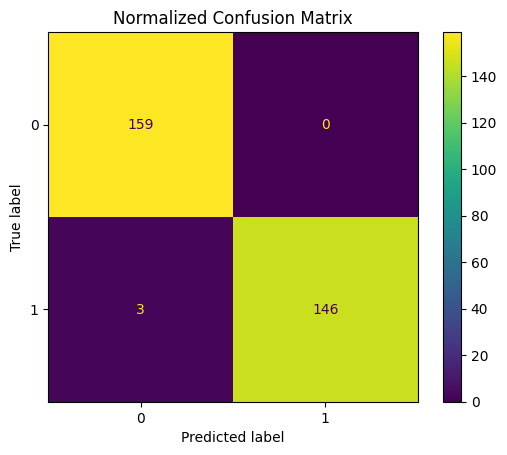

In [15]:

y_pred = final_clf.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(final_clf, X_test, y_test)
plt.title("Normalized Confusion Matrix")
plt.show()


## 🧠 Feature Importance with SHAP

We'll use SHAP (SHapley Additive exPlanations) to understand how different features contribute to the model's predictions.

This helps us:
- Identify the most influential features
- Understand direction and magnitude of impact


### 📊 Interpreting the SHAP Summary Plot

The SHAP summary plot visualizes how each feature contributes to the model's output across all samples. Here's what each component means:

| Element                      | Description                                                                                      |
|-----------------------------|--------------------------------------------------------------------------------------------------|
| **Y-axis (Feature Names)**  | Features are sorted by overall importance (top = most important).                              |
| **X-axis (SHAP value)**     | The impact of that feature on the model's prediction.                                           |
| **Each Dot**                | A single row/sample in the dataset.                                                             |
| **Color (Dot Hue)**         | The feature value for that sample — red = high, blue = low.                                    |
| **Direction of SHAP Value**| Positive SHAP value pushes the prediction toward the positive class (e.g., "disease" class).    |
|                             | Negative SHAP value pushes it toward the negative class (e.g., "no disease").                   |

**🧠 Example Interpretation:**  
If the “Age” feature has mostly red dots (high values) with positive SHAP values, it means higher ages are pushing predictions toward the positive class.


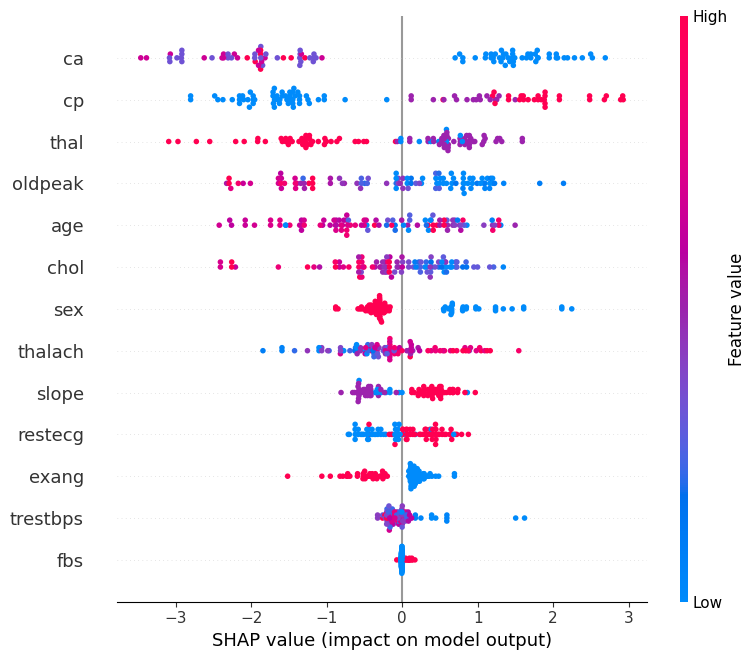

In [ ]:
import shap

explainer = shap.Explainer(final_clf, X_train)
n_datapoints = 100
shap_values = explainer(X_test[:n_datapoints])

shap.summary_plot(shap_values, X_test[:n_datapoints])
